<a href="https://colab.research.google.com/github/harunpirim/graph-data-science-course/blob/main/notebooks/GNN_action/chapter_4/GNN_GAT_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Chapter 5 - Spam Detection of Chicago Yelp Reviews

###Part 1: EDA and Baseline Models

This notebook demonstrates the problem outlined in chapter 5, which applies machine learning models to the YelpChi dataset, a collection of labeled reviews from Chicago restaurants.

In part 1, we perform data exploration and apply baseline models. This notebook comprises 3 main parts:

1. **Data Preparation and Exploration**: The code begins by loading and preparing the dataset, which includes features and labels. It also generates adjacency lists for graph data. Initial data exploration is conducted through histograms to visualize feature distributions. The dataset is split into training and testing sets. Then code checks for class balance in the training data are done.

2. **Model Training and Evaluation**: Three baseline models—logistic regression, XGBoost, and a multi-layer perceptron (MLP)—are trained on the training data. The code calculates and displays key performance metrics, such as ROC AUC, F1-score, precision, and recall, for each model.

3. ROC Curve Visualization: To visually compare the models' classification performance, ROC curves are plotted for each model, providing a clear understanding of their discriminative abilities.

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
# # Use the above information to fill in the http address below
# %%capture
# !pip install ogb pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
# !pip install torch-geometric

In [2]:
import torch
import pickle
import random as rd
import numpy as np
import scipy.sparse as sp
from scipy.io import loadmat
import copy as cp
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score, average_precision_score
from collections import defaultdict


def sparse_to_adjlist(sp_matrix, filename):
	"""
	Transfer sparse matrix to adjacency list
	:param sp_matrix: the sparse matrix
	:param filename: the filename of adjlist
	"""
	# add self loop
	homo_adj = sp_matrix + sp.eye(sp_matrix.shape[0])
	# create adj_list
	adj_lists = defaultdict(set)
	edges = homo_adj.nonzero()
	for index, node in enumerate(edges[0]):
		adj_lists[node].add(edges[1][index])
		adj_lists[edges[1][index]].add(node)
	with open(filename, 'wb') as file:
		pickle.dump(adj_lists, file)
	file.close()

Note on data: The data files can be found in the repository under the chapter 5 directory. In the colab environment, these files can be uploaded to your folder of choice. Once the folder is chosen, adjust the 'prefix' variables accordingly.

When the file is uploaded, restart the instance.

Often this cell must be run 2 or 3 times for it to work.

In [3]:
!unzip 'YelpChi.zip'

Archive:  YelpChi.zip
  inflating: yelp_homo_adjlists.pickle  
  inflating: yelp_rsr_adjlists.pickle  
  inflating: yelp_rtr_adjlists.pickle  
  inflating: yelp_rur_adjlists.pickle  
  inflating: YelpChi.mat             
  inflating: __MACOSX/._YelpChi.mat  


In [4]:
prefix = '/content/'

data_file = loadmat('/content/YelpChi.mat')


labels = data_file['label'].flatten()
features = data_file['features'].todense().A

yelp_homo = data_file['homo'] #C
sparse_to_adjlist(yelp_homo, prefix + 'yelp_homo_adjlists.pickle') #C


# load the preprocessed adj_lists
with open(prefix + 'yelp_homo_adjlists.pickle', 'rb') as file:
    homogenous = pickle.load(file)
file.close()


###I. Data Exploration

EDA is performed on the dataset, which consists of 32 features

In [5]:
# shape of feature dataset
print(f'number of entries = {features.shape[0]}, number of features = {features.shape[1]}')

number of entries = 45954, number of features = 32


In [6]:
# number of classes and percentage attributed
print(f'number of classes  = {np.unique(labels)}')
print(f'percentage false = {100*labels.sum()/len(labels):.2f}%')

# low percentage of false shows a high class imbalance

number of classes  = [0 1]
percentage false = 14.53%


In [7]:
#Note current data is float64 and int64. Both need to be translated into torch tensors when using pytorch geometric
print(f'features dtype = {features.dtype}, \n' +
      f'label dtype = {labels.dtype}')


features dtype = float64, 
label dtype = int64


In [8]:
features.shape

(45954, 32)

In [9]:
feature_names = ['Rank', 'RD', 'EXT', 'DEV', 'ETF', 'ISR', 'PCW', 'PC', 'L', 'PP1',\
                 'RES', 'SW', 'OW', 'DL_u', 'DL_b', 'MNR_user', 'PR_user',\
                 'NR_user', 'avgRD_user', 'WRD_user', 'BST_user', 'ERD_user',\
                 'ETG_user', 'RL_user', 'MNR_prod', 'PR_prod', 'NR_prod', \
                 'avgRD_prod', 'WRD_prod', 'ERD_prod', 'ETG_prod', 'RL_prod']

In [10]:
feature_names_short_desc_all = ['Rank\nRank order among all the reviews of product',
'RD\nAbsolute rating deviation',
'EXT\nExtremity of rating',
'DEV\nThresholded rating deviation',
'ETF\nEarly time frame',
'ISR\nIs review user’s sole review',
'PCW\nPercentage of ALL-capitals words',
'PC\nPercentage of capital letters',
'L\nReview length in words',
'PP1\nRatio of 1st person pronouns',
'RES\nRatio of sentences containing ‘!’',
'SW\nRatio of subjective words',
'OW\nRatio of objective words',
'DL_u\nLength based on uni-grams',
'DL_b\nLength based on bi-grams',
'MNR_user\nMax # of reviews in a day',
'PR_user\nRatio of positive reviews',
'NR_user\nRatio of negative reviews',
'avgRD_user\nAverage rating deviation',
'WRD_user\nWeighted rating deviation',
'BST_user\nBurstiness of reviews',
'ERD_user\nEntropy of rating distribution',
'ETG_user\nEntropy of temporal gaps ∆t’s',
'RL_user\nAvg review length in # of words',
'MNR_prod\nMax # of reviews written in a day',
'PR_prod\nRatio of positive reviews',
'NR_prod\nRatio of negative reviews',
'avgRD_prod\nAverage rating deviation',
'WRD_prod\nWeighted rating deviation',
'ERD_prod\nEntropy of rating distribution',
'ETG_prod\nEntropy of temporal gaps ∆t’s',
'RL_prod\nAvg review length in # of words',]

In [11]:
feature_names_short_desc_review = ['Rank\nRank order among all the reviews of product',
'RD\nAbsolute rating deviation',
'EXT\nExtremity of rating',
'DEV\nThresholded rating deviation',
'ETF\nEarly time frame',
'ISR\nIs review user’s sole review',
'PCW\nPercentage of ALL-capitals words',
'PC\nPercentage of capital letters',
'L\nReview length in words',
'PP1\nRatio of 1st person pronouns',
'RES\nRatio of sentences containing ‘!’',
'SW\nRatio of subjective words',
'OW\nRatio of objective words',
'DL_u\nLength based on uni-grams',
'DL_b\nLength based on bi-grams',]

In [12]:
feature_names_short_desc_user = [
'MNR_user\nMax # of reviews in a day',
'PR_user\nRatio of positive reviews',
'NR_user\nRatio of negative reviews',
'avgRD_user\nAverage rating deviation',
'WRD_user\nWeighted rating deviation',
'BST_user\nBurstiness of reviews',
'ERD_user\nEntropy of rating distribution',
'ETG_user\nEntropy of temporal gaps ∆t’s',
'RL_user\nAvg review length in # of words',]

In [13]:
feature_names_short_desc_product = [
'MNR_prod\nMax # of reviews written in a day',
'PR_prod\nRatio of positive reviews',
'NR_prod\nRatio of negative reviews',
'avgRD_prod\nAverage rating deviation',
'WRD_prod\nWeighted rating deviation',
'ERD_prod\nEntropy of rating distribution',
'ETG_prod\nEntropy of temporal gaps ∆t’s',
'RL_prod\nAvg review length in # of words',]

In [ ]:
# feature_names

Distribution plots of all the features. Note: these features have been pre-processed to be normalized.

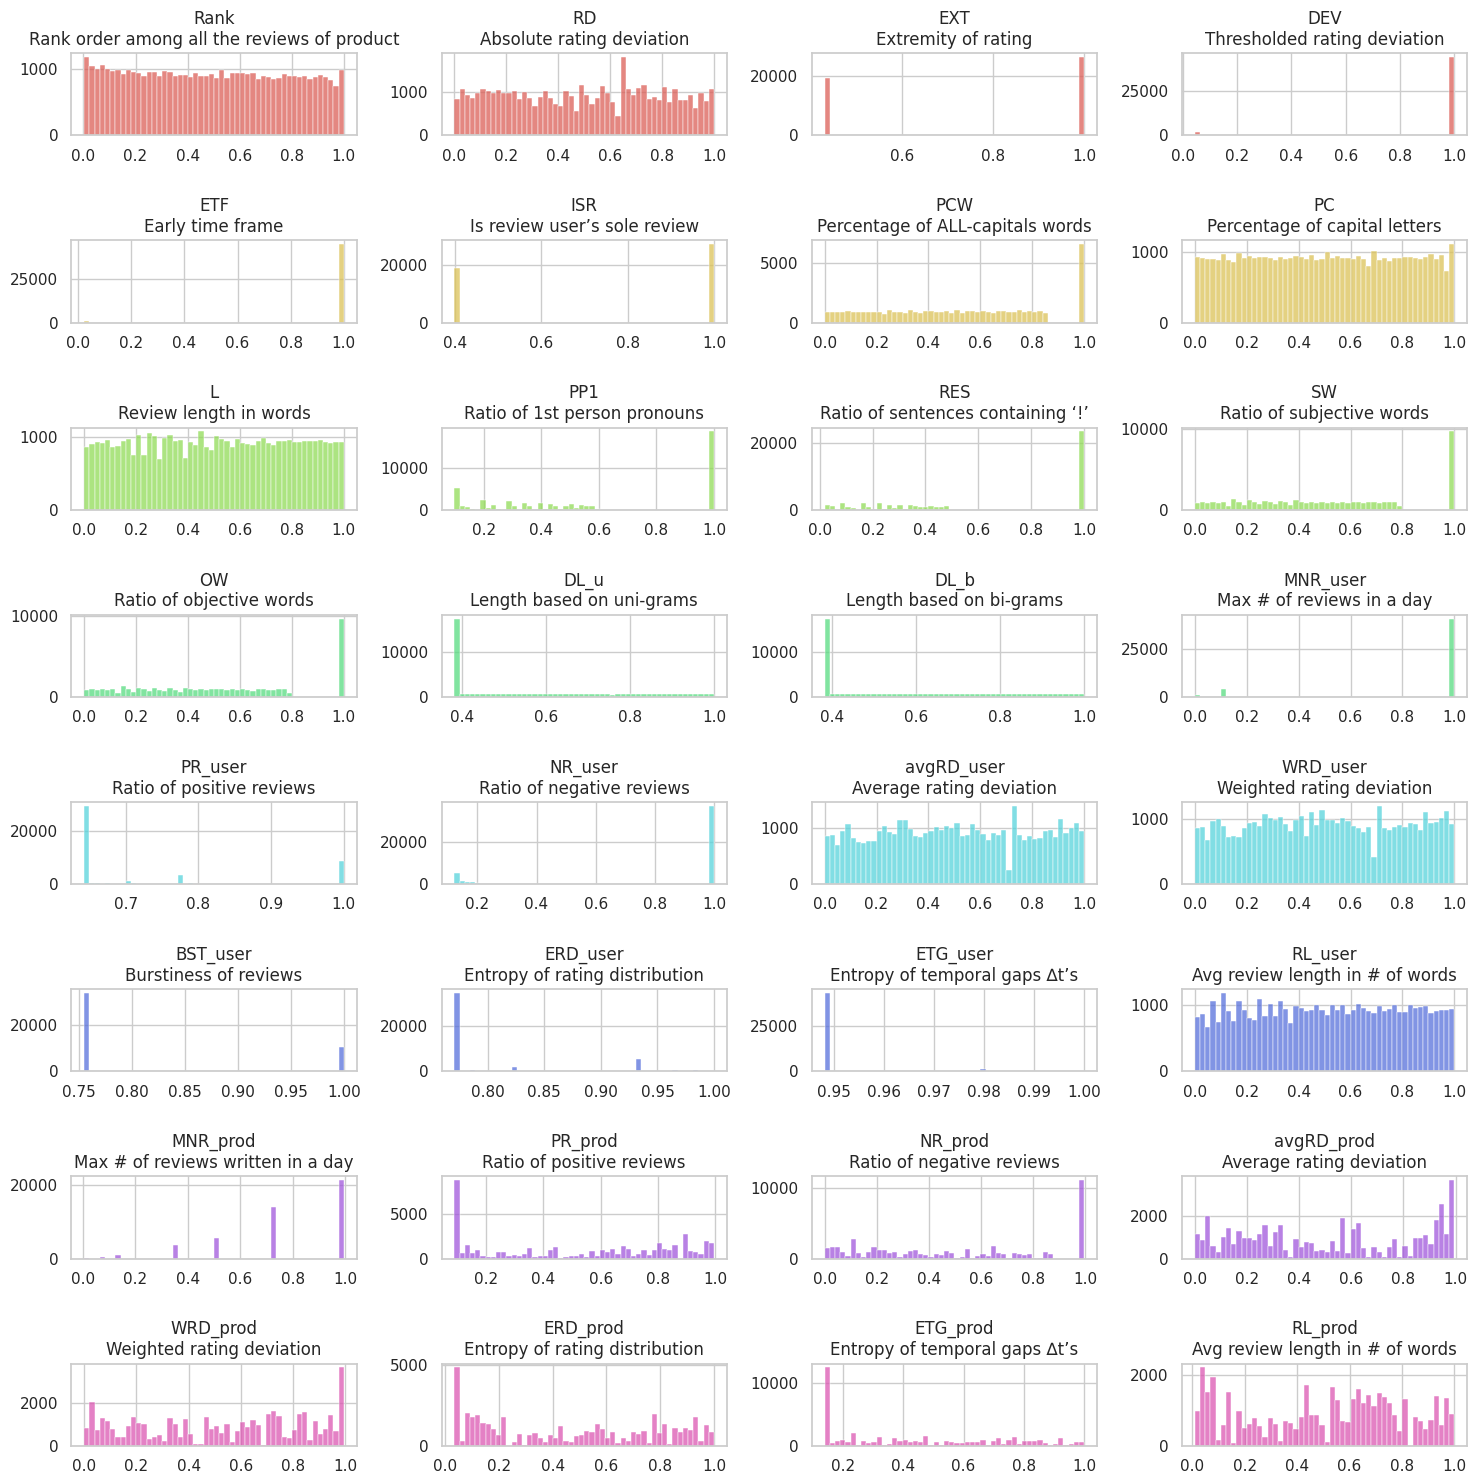

In [14]:
import seaborn as sns
sns.set(style="whitegrid")

fig, ax = plt.subplots(8, 4, figsize=(15, 15))
colors = sns.color_palette("hls", 8)
for i in range(8):
    for j in range(4):
        sns.histplot(features[:, 4*i+j], bins=50, ax=ax[i, j], color=colors[i])
        ax[i, j].set(xlabel='', ylabel='')
        ax[i, j].set_title(feature_names_short_desc_all[4*i+j])
plt.tight_layout(h_pad=2.0)


Distribution plots of Review-based features.

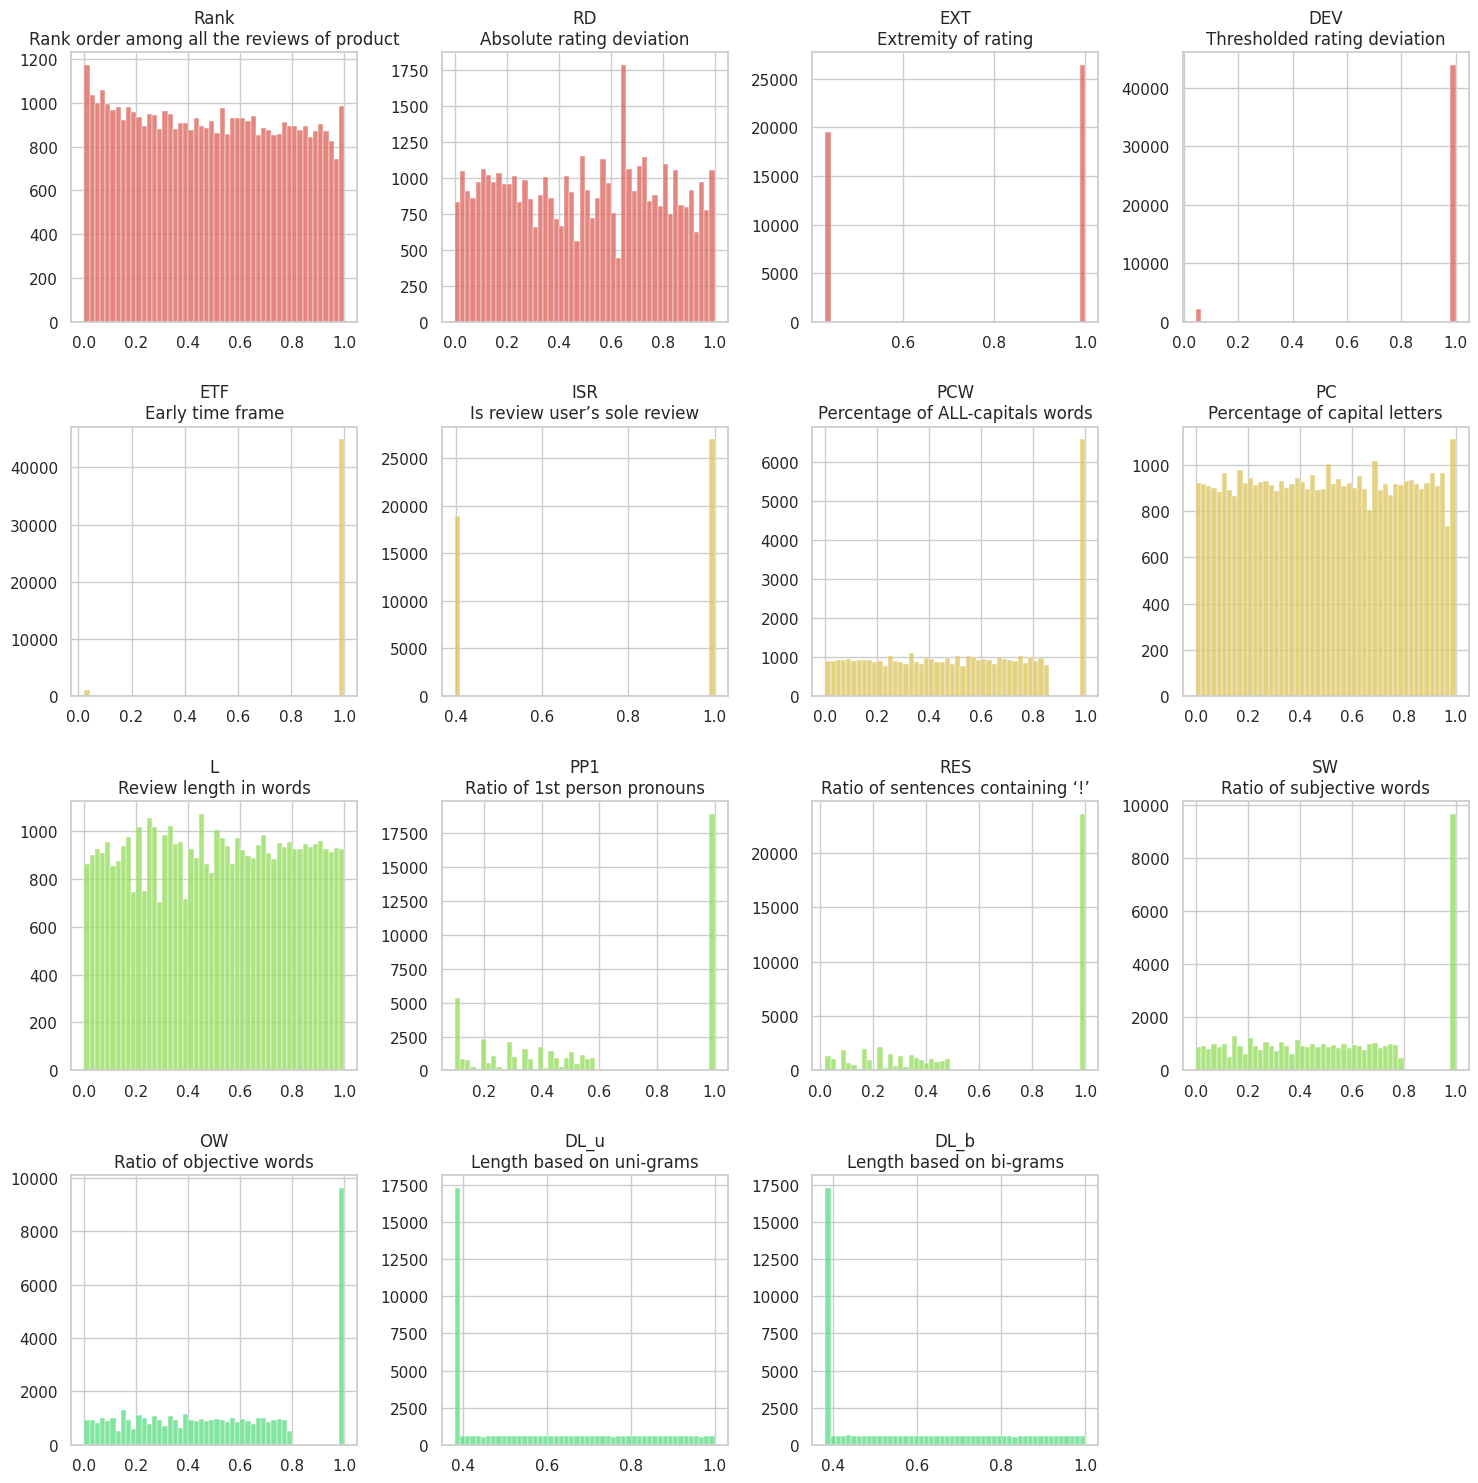

In [15]:
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
colors = sns.color_palette("hls", 8)
for i in range(4):
    for j in range(4):
        if i==3 and j > 2:
            ax[i, j].remove()
            continue
        sns.histplot(features[:, 4*i+j], bins=50, ax=ax[i, j], color=colors[i], stat='count')
        ax[i, j].set(xlabel='', ylabel='')
        ax[i, j].set_title(feature_names_short_desc_review[4*i+j])
plt.tight_layout(h_pad=2.0)

Distribution plots of User-based features.

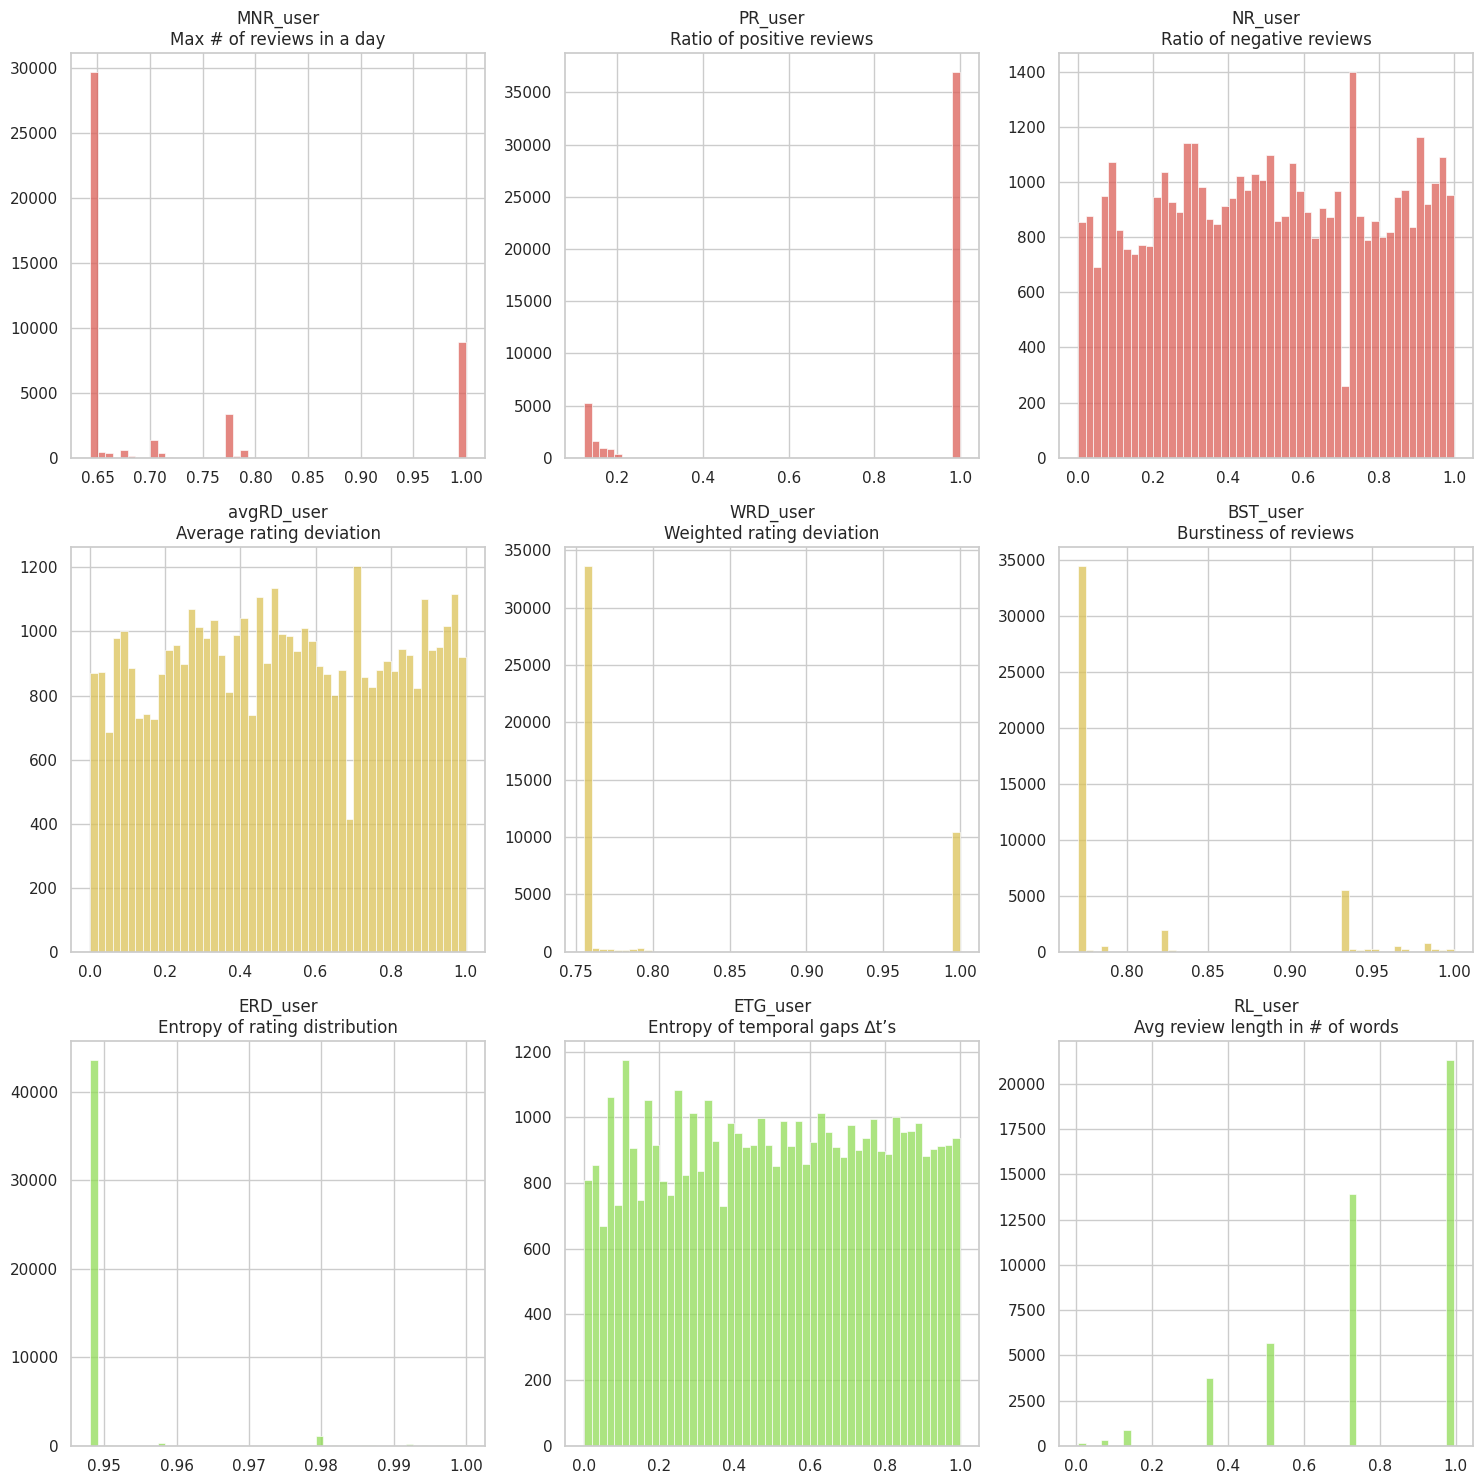

In [16]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
colors = sns.color_palette("hls", 8)
cnt=15
for i in range(3):
    for j in range(3):
        cnt+=1
        sns.histplot(features[:, cnt], bins=50, ax=ax[i, j], color=colors[i], stat='count')
        # sns.displot(features[:, cnt], bins=50, ax=ax[i, j], color=colors[i], )
        ax[i, j].set(xlabel='', ylabel='')
        ax[i, j].set_title(feature_names_short_desc_user[3*i+j])
plt.tight_layout()

Distribution plots of Product-based features.

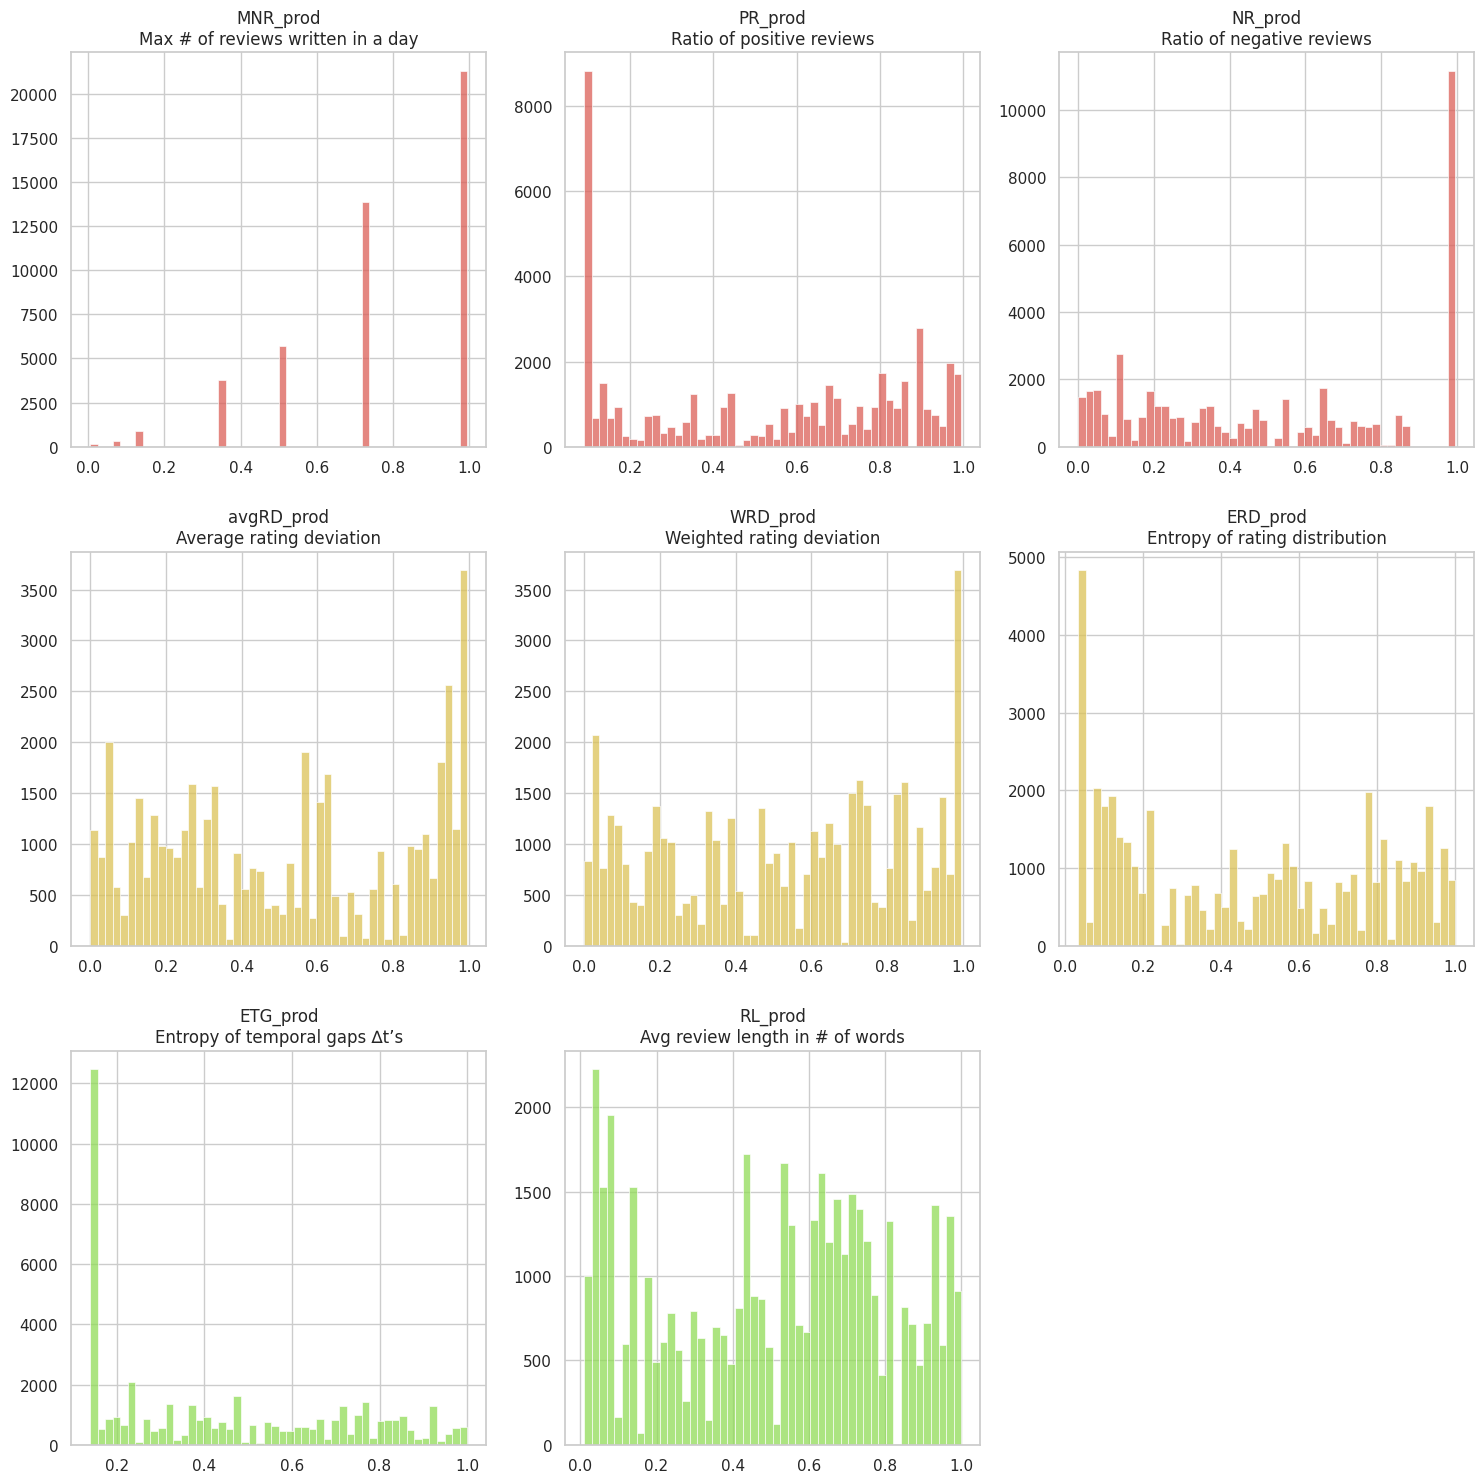

In [17]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
colors = sns.color_palette("hls", 8)
cnt = 23
for i in range(3):
    for j in range(3):
        cnt+=1
        if i==2 and j > 1:
            ax[i, j].remove()
            continue
        sns.histplot(features[:, cnt],  bins=50, ax=ax[i, j], color=colors[i], stat='count')
        ax[i, j].set(xlabel='', ylabel='')
        ax[i, j].set_title(feature_names_short_desc_product[3*i+j])
plt.tight_layout(h_pad=2.0)

----
Convert the numpy array of features into a pandas dataframe. Apply a pairplot to the features (optional, as this will take a while).

In [18]:
type(features)

numpy.ndarray

In [19]:
features_df = pd.DataFrame(features, columns=feature_names)

In [20]:
features_df.head()

,Rank,RD,EXT,DEV,ETF,ISR,PCW,PC,L,PP1,...,ETG_user,RL_user,MNR_prod,PR_prod,NR_prod,avgRD_prod,WRD_prod,ERD_prod,ETG_prod,RL_prod
0,0.022376,0.070495,0.428682,0.999985,0.999985,0.398457,0.823592,0.497025,0.965457,0.150263,...,0.94806,0.867772,0.995025,0.910448,0.079602,0.00995,0.014925,0.59204,0.139303,0.497512
1,0.024928,0.999985,0.999985,0.999985,0.999985,0.398457,0.999985,0.941257,0.217850,0.098019,...,0.94806,0.826367,0.995025,0.910448,0.079602,0.00995,0.014925,0.59204,0.139303,0.497512
2,0.006173,0.070495,0.428682,0.999985,0.999985,0.398457,0.057230,0.151243,0.841056,1.000000,...,0.94806,0.802564,0.995025,0.910448,0.079602,0.00995,0.014925,0.59204,0.139303,0.497512
3,0.017375,0.070495,0.428682,0.999985,0.999985,0.398457,0.999985,0.930203,0.025402,0.098019,...,0.94806,0.387121,0.995025,0.910448,0.079602,0.00995,0.014925,0.59204,0.139303,0.497512
4,0.009081,0.999985,0.999985,0.999985,0.999985,0.398457,0.159374,0.697188,0.195489,1.000000,...,0.94806,0.246985,0.995025,0.910448,0.079602,0.00995,0.014925,0.59204,0.139303,0.497512


Optional pairplot commands. Commented out to avoid a long wait.)

In [ ]:
# sns.pairplot(features_df.iloc[:, :15])

In [ ]:
# sns.pairplot(features_df.iloc[:, 15:23])

In [ ]:
# sns.pairplot(features_df.iloc[:, 23:32])

###II. Data Preprocessing and **Training**

In [21]:
# split data into test and train
from sklearn.model_selection import train_test_split
split = 0.2
xtrain, xtest, ytrain, ytest = train_test_split(features, labels, test_size = split,
                                                                    stratify=labels,
                                                                    random_state = 99)


In [22]:
from collections import Counter

def check_balance(labels):
    counter = Counter(labels)
    for k, v in counter.items():
        per = v / len(labels) * 100
        print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# assuming 'y' is your labels
check_balance(ytrain)

Class=1, n=5342 (14.531%)
Class=0, n=31421 (85.469%)


In [23]:
print(ytrain.sum()/len(ytrain))
print(ytest.sum()/len(ytest))


0.14530914234420478
0.14525078881514525


In [24]:
#double check shapes
print(f'Required shape is {int(len(features)*(1-split))}')
print(f'xtrain shape = {xtrain.shape}, xtest shape = {xtest.shape}')
print(f'Correct split = {int(len(features)*(1-split)) == xtrain.shape[0]}')

Required shape is 36763
xtrain shape = (36763, 32), xtest shape = (9191, 32)
Correct split = True


####Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

# Fit the logistic regression model
clf = LogisticRegression(random_state=0).fit(xtrain, ytrain)

# Predict probabilities
ypred_proba = clf.predict_proba(xtest)[:, 1]

# Convert probabilities to binary labels
ypred_binary = (ypred_proba > 0.5).astype(int)

# Calculate ROC AUC score
roc_auc = roc_auc_score(ytest, ypred_proba)

# Calculate F1-score, Precision, and Recall
f1 = f1_score(ytest, ypred_binary)
precision = precision_score(ytest, ypred_binary)
recall = recall_score(ytest, ypred_binary)

print(f"Model ROC AUC (logistic regression) = {100 * roc_auc:.2f}%")
print(f"Model F1-score (logistic regression) = {f1:.3f}")
print(f"Model Precision (logistic regression) = {precision:.3f}")
print(f"Model Recall (logistic regression) = {recall:.3f}")


Model ROC AUC (logistic regression) = 75.89%
Model F1-score (logistic regression) = 0.213
Model Precision (logistic regression) = 0.597
Model Recall (logistic regression) = 0.130


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


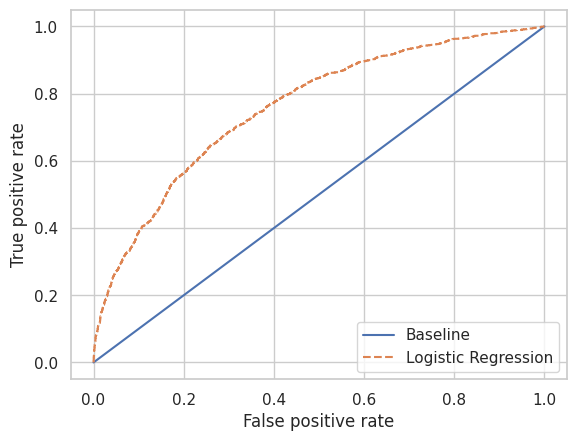

In [26]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(ytest,ypred_proba)

plt.figure(1)
plt.plot([0, 1], [0, 1], linestyle='-', label='Baseline')
plt.plot(fpr, tpr, linestyle='--', label='Logistic Regression')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')

plt.show()

####XGBoost

In [27]:
# ## Apply XGBoost for second baseline
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
xgb_classifier = xgb.XGBClassifier()

In [28]:
# Initialize and fit the XGBoost classifier
xgb_classifier = XGBClassifier()
xgb_classifier.fit(xtrain, ytrain)

# Predict probabilities for the test set
ypred_proba = xgb_classifier.predict_proba(xtest)[:, 1]

# Convert probabilities to binary labels based on a threshold (0.5 used here)
ypred_binary = (ypred_proba > 0.5).astype(int)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(ytest, ypred_proba)

# Calculate F1-score, Precision, and Recall
f1 = f1_score(ytest, ypred_binary)
precision = precision_score(ytest, ypred_binary)
recall = recall_score(ytest, ypred_binary)

# Print the scores
print(f"Model ROC AUC (XGBoost) = {100 * roc_auc:.2f}%")
print(f"Model F1-score (XGBoost) = {f1:.3f}")
print(f"Model Precision (XGBoost) = {precision:.3f}")
print(f"Model Recall (XGBoost) = {recall:.3f}")

Model ROC AUC (XGBoost) = 95.37%
Model F1-score (XGBoost) = 0.728
Model Precision (XGBoost) = 0.851
Model Recall (XGBoost) = 0.637


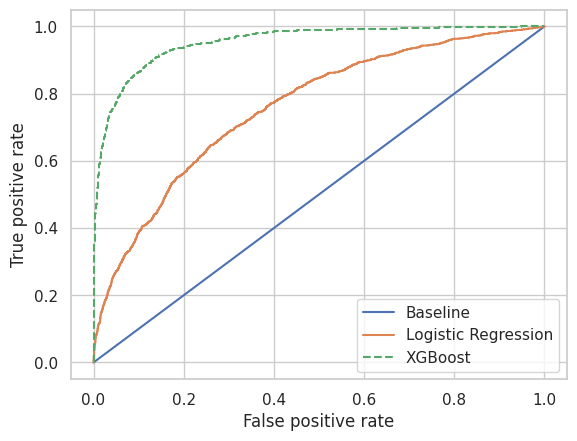

In [29]:
fpr2, tpr2, _ = roc_curve(ytest,ypred_proba)

plt.figure(1)
plt.plot([0, 1], [0, 1], label='Baseline')
plt.plot(fpr, tpr, linestyle='-', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--', label='XGBoost')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')

plt.show()

####MLP

In [30]:
# Apply MLP for third baseline

import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        layers = []
        layers.append(nn.Linear(32, 30)) # First layer
        layers.append(nn.ReLU()) # Activation function
        layers.append(nn.Dropout(0.5)) # Dropout layer

        for i in range(20): # 20 hidden layers
            layers.append(nn.Linear(30, 30)) # Add a linear layer
            layers.append(nn.ReLU()) # Add activation function
            layers.append(nn.Dropout(0.5)) # Dropout layer

        layers.append(nn.Linear(30, 50)) # Another linear layer
        layers.append(nn.ReLU()) # Activation function
        layers.append(nn.Dropout(0.5)) # Dropout layer
        layers.append(nn.Linear(50, 1)) # Final layer
        layers.append(nn.Sigmoid()) # Activation function

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return x.view(-1, 1)

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Assume xtrain, ytrain, xtest, and ytest are already defined and preprocessed
# Their shapes should be: xtrain(62842, 32), xtest(9191, 32)

# Convert data to PyTorch tensors
xtrain = torch.FloatTensor(xtrain)
ytrain = torch.LongTensor(ytrain)
xtest = torch.FloatTensor(xtest)
ytest = torch.LongTensor(ytest)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(32, 64),  # Input size is 32 to match the number of features
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Initialize model, criterion, and optimizer
model = MLP()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 10000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    output = model(xtrain).squeeze()
    loss = criterion(output, ytrain.float())
    loss.backward()
    optimizer.step()

    # Evaluation
    with torch.no_grad():
        model.eval()
        test_output = model(xtest).squeeze()
        test_prob = torch.sigmoid(test_output)
        ypred_proba = test_prob.numpy()
        ypred_binary = (ypred_proba > 0.5).astype(int)

        roc_auc = roc_auc_score(ytest, ypred_proba)
        f1 = f1_score(ytest, ypred_binary)
        precision = precision_score(ytest, ypred_binary)
        recall = recall_score(ytest, ypred_binary)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Loss: {loss.item():.4f} | "
          f"ROC AUC: {roc_auc:.3f} | "
          f"F1-score: {f1:.3f} | "
          f"Precision: {precision:.3f} | "
          f"Recall: {recall:.3f}")


Epoch 1/10000 | Loss: 0.6919 | ROC AUC: 0.517 | F1-score: 0.146 | Precision: 0.165 | Recall: 0.131
Epoch 2/10000 | Loss: 0.6720 | ROC AUC: 0.523 | F1-score: 0.025 | Precision: 0.171 | Recall: 0.013
Epoch 3/10000 | Loss: 0.6528 | ROC AUC: 0.528 | F1-score: 0.001 | Precision: 0.200 | Recall: 0.001
Epoch 4/10000 | Loss: 0.6343 | ROC AUC: 0.533 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 5/10000 | Loss: 0.6165 | ROC AUC: 0.538 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 6/10000 | Loss: 0.5994 | ROC AUC: 0.542 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 7/10000 | Loss: 0.5829 | ROC AUC: 0.546 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 8/10000 | Loss: 0.5672 | ROC AUC: 0.550 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

Epoch 9/10000 | Loss: 0.5521 | ROC AUC: 0.554 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 10/10000 | Loss: 0.5377 | ROC AUC: 0.556 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 11/10000 | Loss: 0.5240 | ROC AUC: 0.559 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 12/10000 | Loss: 0.5111 | ROC AUC: 0.561 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 13/10000 | Loss: 0.4989 | ROC AUC: 0.563 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 14/10000 | Loss: 0.4874 | ROC AUC: 0.564 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 15/10000 | Loss: 0.4768 | ROC AUC: 0.566 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 16/10000 | Loss: 0.4669 | ROC AUC: 0.567 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 17/10000 | Loss: 0.4579 | ROC AUC: 0.568 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

Epoch 18/10000 | Loss: 0.4497 | ROC AUC: 0.569 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 19/10000 | Loss: 0.4423 | ROC AUC: 0.570 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 20/10000 | Loss: 0.4358 | ROC AUC: 0.571 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 21/10000 | Loss: 0.4301 | ROC AUC: 0.571 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 22/10000 | Loss: 0.4252 | ROC AUC: 0.572 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 23/10000 | Loss: 0.4212 | ROC AUC: 0.573 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 24/10000 | Loss: 0.4179 | ROC AUC: 0.573 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 25/10000 | Loss: 0.4154 | ROC AUC: 0.574 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 26/10000 | Loss: 0.4136 | ROC AUC: 0.575 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

Epoch 27/10000 | Loss: 0.4124 | ROC AUC: 0.575 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 28/10000 | Loss: 0.4118 | ROC AUC: 0.576 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 29/10000 | Loss: 0.4116 | ROC AUC: 0.577 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 30/10000 | Loss: 0.4117 | ROC AUC: 0.578 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 31/10000 | Loss: 0.4121 | ROC AUC: 0.579 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 32/10000 | Loss: 0.4126 | ROC AUC: 0.580 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 33/10000 | Loss: 0.4132 | ROC AUC: 0.581 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 34/10000 | Loss: 0.4137 | ROC AUC: 0.582 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 35/10000 | Loss: 0.4142 | ROC AUC: 0.584 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

Epoch 36/10000 | Loss: 0.4145 | ROC AUC: 0.585 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 37/10000 | Loss: 0.4147 | ROC AUC: 0.587 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 38/10000 | Loss: 0.4147 | ROC AUC: 0.588 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 39/10000 | Loss: 0.4146 | ROC AUC: 0.589 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 40/10000 | Loss: 0.4144 | ROC AUC: 0.591 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 41/10000 | Loss: 0.4141 | ROC AUC: 0.593 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 42/10000 | Loss: 0.4136 | ROC AUC: 0.594 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 43/10000 | Loss: 0.4132 | ROC AUC: 0.596 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

Epoch 44/10000 | Loss: 0.4127 | ROC AUC: 0.597 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 45/10000 | Loss: 0.4122 | ROC AUC: 0.599 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 46/10000 | Loss: 0.4117 | ROC AUC: 0.600 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 47/10000 | Loss: 0.4113 | ROC AUC: 0.602 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 48/10000 | Loss: 0.4108 | ROC AUC: 0.603 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 49/10000 | Loss: 0.4104 | ROC AUC: 0.605 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 50/10000 | Loss: 0.4101 | ROC AUC: 0.607 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 51/10000 | Loss: 0.4098 | ROC AUC: 0.609 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 52/10000 | Loss: 0.4095 | ROC AUC: 0.611 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

Epoch 53/10000 | Loss: 0.4092 | ROC AUC: 0.614 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 54/10000 | Loss: 0.4090 | ROC AUC: 0.616 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 55/10000 | Loss: 0.4088 | ROC AUC: 0.619 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 56/10000 | Loss: 0.4087 | ROC AUC: 0.621 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 57/10000 | Loss: 0.4085 | ROC AUC: 0.624 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 58/10000 | Loss: 0.4083 | ROC AUC: 0.627 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 59/10000 | Loss: 0.4082 | ROC AUC: 0.630 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 60/10000 | Loss: 0.4080 | ROC AUC: 0.633 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 61/10000 | Loss: 0.4078 | ROC AUC: 0.636 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

Epoch 62/10000 | Loss: 0.4077 | ROC AUC: 0.639 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 63/10000 | Loss: 0.4076 | ROC AUC: 0.642 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 64/10000 | Loss: 0.4074 | ROC AUC: 0.644 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 65/10000 | Loss: 0.4073 | ROC AUC: 0.646 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 66/10000 | Loss: 0.4071 | ROC AUC: 0.649 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 67/10000 | Loss: 0.4069 | ROC AUC: 0.651 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 68/10000 | Loss: 0.4067 | ROC AUC: 0.652 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 69/10000 | Loss: 0.4065 | ROC AUC: 0.654 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 70/10000 | Loss: 0.4063 | ROC AUC: 0.656 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

Epoch 71/10000 | Loss: 0.4061 | ROC AUC: 0.658 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 72/10000 | Loss: 0.4058 | ROC AUC: 0.659 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 73/10000 | Loss: 0.4056 | ROC AUC: 0.661 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 74/10000 | Loss: 0.4053 | ROC AUC: 0.662 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 75/10000 | Loss: 0.4051 | ROC AUC: 0.664 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 76/10000 | Loss: 0.4049 | ROC AUC: 0.665 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 77/10000 | Loss: 0.4046 | ROC AUC: 0.667 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 78/10000 | Loss: 0.4044 | ROC AUC: 0.668 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 79/10000 | Loss: 0.4042 | ROC AUC: 0.670 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

Epoch 80/10000 | Loss: 0.4040 | ROC AUC: 0.671 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 81/10000 | Loss: 0.4037 | ROC AUC: 0.673 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 82/10000 | Loss: 0.4035 | ROC AUC: 0.674 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 83/10000 | Loss: 0.4033 | ROC AUC: 0.676 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 84/10000 | Loss: 0.4031 | ROC AUC: 0.677 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 85/10000 | Loss: 0.4029 | ROC AUC: 0.679 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 86/10000 | Loss: 0.4026 | ROC AUC: 0.680 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 87/10000 | Loss: 0.4024 | ROC AUC: 0.682 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

Epoch 88/10000 | Loss: 0.4021 | ROC AUC: 0.683 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 89/10000 | Loss: 0.4019 | ROC AUC: 0.685 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 90/10000 | Loss: 0.4016 | ROC AUC: 0.686 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 91/10000 | Loss: 0.4014 | ROC AUC: 0.687 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 92/10000 | Loss: 0.4011 | ROC AUC: 0.689 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 93/10000 | Loss: 0.4008 | ROC AUC: 0.690 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 94/10000 | Loss: 0.4006 | ROC AUC: 0.691 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 95/10000 | Loss: 0.4003 | ROC AUC: 0.692 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 96/10000 | Loss: 0.4000 | ROC AUC: 0.693 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

Epoch 97/10000 | Loss: 0.3997 | ROC AUC: 0.694 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 98/10000 | Loss: 0.3995 | ROC AUC: 0.695 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 99/10000 | Loss: 0.3992 | ROC AUC: 0.696 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 100/10000 | Loss: 0.3989 | ROC AUC: 0.697 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 101/10000 | Loss: 0.3986 | ROC AUC: 0.698 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 102/10000 | Loss: 0.3984 | ROC AUC: 0.699 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 103/10000 | Loss: 0.3981 | ROC AUC: 0.699 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 104/10000 | Loss: 0.3978 | ROC AUC: 0.700 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 105/10000 | Loss: 0.3975 | ROC AUC: 0.701 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

Epoch 106/10000 | Loss: 0.3972 | ROC AUC: 0.701 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 107/10000 | Loss: 0.3969 | ROC AUC: 0.702 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 108/10000 | Loss: 0.3966 | ROC AUC: 0.702 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 109/10000 | Loss: 0.3963 | ROC AUC: 0.703 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 110/10000 | Loss: 0.3960 | ROC AUC: 0.704 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 111/10000 | Loss: 0.3957 | ROC AUC: 0.704 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 112/10000 | Loss: 0.3954 | ROC AUC: 0.705 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 113/10000 | Loss: 0.3951 | ROC AUC: 0.705 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 114/10000 | Loss: 0.3948 | ROC AUC: 0.706 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

Epoch 115/10000 | Loss: 0.3945 | ROC AUC: 0.706 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 116/10000 | Loss: 0.3942 | ROC AUC: 0.707 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 117/10000 | Loss: 0.3938 | ROC AUC: 0.707 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 118/10000 | Loss: 0.3935 | ROC AUC: 0.708 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 119/10000 | Loss: 0.3932 | ROC AUC: 0.708 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 120/10000 | Loss: 0.3929 | ROC AUC: 0.708 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 121/10000 | Loss: 0.3926 | ROC AUC: 0.709 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 122/10000 | Loss: 0.3923 | ROC AUC: 0.709 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 123/10000 | Loss: 0.3920 | ROC AUC: 0.710 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

Epoch 124/10000 | Loss: 0.3916 | ROC AUC: 0.710 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 125/10000 | Loss: 0.3913 | ROC AUC: 0.710 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 126/10000 | Loss: 0.3910 | ROC AUC: 0.711 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 127/10000 | Loss: 0.3907 | ROC AUC: 0.711 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 128/10000 | Loss: 0.3904 | ROC AUC: 0.712 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 129/10000 | Loss: 0.3900 | ROC AUC: 0.712 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 130/10000 | Loss: 0.3897 | ROC AUC: 0.712 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 131/10000 | Loss: 0.3894 | ROC AUC: 0.713 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 132/10000 | Loss: 0.3891 | ROC AUC: 0.713 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

Epoch 133/10000 | Loss: 0.3888 | ROC AUC: 0.713 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 134/10000 | Loss: 0.3884 | ROC AUC: 0.714 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 135/10000 | Loss: 0.3881 | ROC AUC: 0.714 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 136/10000 | Loss: 0.3878 | ROC AUC: 0.714 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 137/10000 | Loss: 0.3875 | ROC AUC: 0.715 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 138/10000 | Loss: 0.3872 | ROC AUC: 0.715 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 139/10000 | Loss: 0.3868 | ROC AUC: 0.716 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 140/10000 | Loss: 0.3865 | ROC AUC: 0.716 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 141/10000 | Loss: 0.3862 | ROC AUC: 0.716 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

Epoch 142/10000 | Loss: 0.3859 | ROC AUC: 0.717 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 143/10000 | Loss: 0.3855 | ROC AUC: 0.717 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 144/10000 | Loss: 0.3852 | ROC AUC: 0.717 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 145/10000 | Loss: 0.3849 | ROC AUC: 0.718 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 146/10000 | Loss: 0.3845 | ROC AUC: 0.718 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 147/10000 | Loss: 0.3842 | ROC AUC: 0.719 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 148/10000 | Loss: 0.3839 | ROC AUC: 0.719 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 149/10000 | Loss: 0.3835 | ROC AUC: 0.720 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 150/10000 | Loss: 0.3832 | ROC AUC: 0.720 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

Epoch 151/10000 | Loss: 0.3829 | ROC AUC: 0.720 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 152/10000 | Loss: 0.3825 | ROC AUC: 0.721 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 153/10000 | Loss: 0.3822 | ROC AUC: 0.721 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 154/10000 | Loss: 0.3819 | ROC AUC: 0.722 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 155/10000 | Loss: 0.3815 | ROC AUC: 0.722 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 156/10000 | Loss: 0.3812 | ROC AUC: 0.722 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 157/10000 | Loss: 0.3809 | ROC AUC: 0.723 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 158/10000 | Loss: 0.3806 | ROC AUC: 0.723 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000
Epoch 159/10000 | Loss: 0.3803 | ROC AUC: 0.723 | F1-score: 0.000 | Precision: 0.000 | Recall: 0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

Streaming output truncated to the last 5000 lines.
Epoch 5001/10000 | Loss: 0.2590 | ROC AUC: 0.860 | F1-score: 0.480 | Precision: 0.658 | Recall: 0.378
Epoch 5002/10000 | Loss: 0.2590 | ROC AUC: 0.860 | F1-score: 0.484 | Precision: 0.651 | Recall: 0.385
Epoch 5003/10000 | Loss: 0.2590 | ROC AUC: 0.860 | F1-score: 0.480 | Precision: 0.658 | Recall: 0.378
Epoch 5004/10000 | Loss: 0.2590 | ROC AUC: 0.860 | F1-score: 0.484 | Precision: 0.650 | Recall: 0.386
Epoch 5005/10000 | Loss: 0.2590 | ROC AUC: 0.860 | F1-score: 0.481 | Precision: 0.659 | Recall: 0.378
Epoch 5006/10000 | Loss: 0.2590 | ROC AUC: 0.860 | F1-score: 0.485 | Precision: 0.651 | Recall: 0.387
Epoch 5007/10000 | Loss: 0.2590 | ROC AUC: 0.860 | F1-score: 0.481 | Precision: 0.659 | Recall: 0.378
Epoch 5008/10000 | Loss: 0.2590 | ROC AUC: 0.860 | F1-score: 0.486 | Precision: 0.650 | Recall: 0.389
Epoch 5009/10000 | Loss: 0.2590 | ROC AUC: 0.860 | F1-score: 0.481 | Precision: 0.660 | Recall: 0.378
Epoch 5010/10000 | Loss: 0.2589

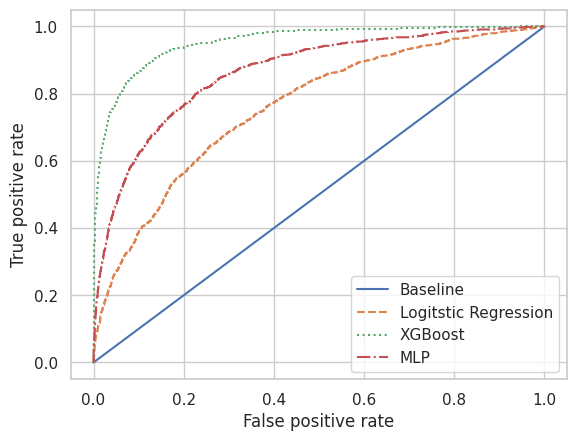

In [32]:
fpr3, tpr3, _ = roc_curve(ytest,ypred_proba)


plt.figure(1)
plt.plot([0, 1], [0, 1], linestyle='-', label='Baseline')  # Use a solid line for the baseline
plt.plot(fpr, tpr, linestyle='--', label='Logitstic Regression')  # Use a dashed line for Model 1
plt.plot(fpr2, tpr2, linestyle=':', label='XGBoost')  # Use a dotted line for Model 2
plt.plot(fpr3, tpr3, linestyle='-.', label='MLP')  # Use a dash-dot line for Model 3
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()